In [21]:
import keras as keras
import pandas as pd
import numpy as np
from sklearn import metrics
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.width', 500)
np.set_printoptions(linewidth=500)
pd.set_option('display.max_columns', 10)

df = pd.read_csv(
    "../../dataset_building/paris_velib_dataset_preprocessed.csv",
    index_col=False
)

df.shape

df.head()

,is_installed,is_renting,is_returning,longitude,latitude,...,record_timestamp_minute_46,record_timestamp_minute_50,record_timestamp_minute_51,record_timestamp_minute_59,record_timestamp_second_0
0,1,1,1,0.023661,0.488710,...,1,0,0,0,1
1,1,1,1,0.023360,0.488375,...,1,0,0,0,1
2,1,1,1,0.023520,0.488439,...,1,0,0,0,1
3,1,1,1,0.023851,0.489104,...,1,0,0,0,1
4,1,1,1,0.023768,0.488158,...,1,0,0,0,1


In [3]:
# 30% of data for testing
train_size = int(len(df) * 0.7)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

66949 28693


In [4]:
feature_columns = list(df.columns)
feature_columns.remove('bike_availability_ratio')

f_columns = feature_columns
f_transformer = RobustScaler()
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(
    train[f_columns].to_numpy()
)
test.loc[:, f_columns] = f_transformer.transform(
    test[f_columns].to_numpy()
)

bike_availability_col = ['bike_availability_ratio']
availability_transformer = RobustScaler()
availability_transformer = availability_transformer.fit(train[bike_availability_col])
train.loc[:, bike_availability_col] = availability_transformer.transform(
    train[bike_availability_col]
)
test.loc[:, bike_availability_col] = availability_transformer.transform(
    test[bike_availability_col]
)

C:\Users\teoma\PycharmProjects\RealtimePredictionBikeTerminalAvailability\venv\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\teoma\PycharmProjects\RealtimePredictionBikeTerminalAvailability\venv\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\teoma\PycharmProjects\RealtimePredictio

In [5]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [59]:
time_steps = 10
X_train, y_train = create_dataset(train, train.bike_availability_ratio, time_steps)
X_test, y_test = create_dataset(test, test.bike_availability_ratio, time_steps)
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_squared_error', patience=2, mode='min'
)
print(X_train.shape, y_train.shape)

model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
        keras.layers.GRU(
            units=128,
            dropout=0.5,
            recurrent_dropout=0.2,
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
)
# model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam',metrics=[tf.keras.losses.MeanSquaredError(),'mae'])

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[callback],
    shuffle=False
)

(66939, 10, 40) (66939,)
Epoch 1/20
1883/1883 [==============================] - 43s 21ms/step - loss: 0.3621 - mean_squared_error: 0.3621 - mae: 0.5162 - val_loss: 0.3188 - val_mean_squared_error: 0.3193 - val_mae: 0.4838
Epoch 2/20
1883/1883 [==============================] - 41s 22ms/step - loss: 0.3555 - mean_squared_error: 0.3555 - mae: 0.5126 - val_loss: 0.3184 - val_mean_squared_error: 0.3190 - val_mae: 0.4832
Epoch 3/20
1883/1883 [==============================] - 40s 21ms/step - loss: 0.3547 - mean_squared_error: 0.3547 - mae: 0.5125 - val_loss: 0.3189 - val_mean_squared_error: 0.3194 - val_mae: 0.4803
Epoch 4/20
1883/1883 [==============================] - 40s 21ms/step - loss: 0.3544 - mean_squared_error: 0.3544 - mae: 0.5124 - val_loss: 0.3189 - val_mean_squared_error: 0.3194 - val_mae: 0.4811


In [60]:
np.abs(model.evaluate(X_train, y_train)[1]-model.evaluate(X_test, y_test)[1])

897/897 [==============================] - 6s 6ms/step - loss: 0.3729 - mean_squared_error: 0.3730 - mae: 0.5330


0.02279236912727356

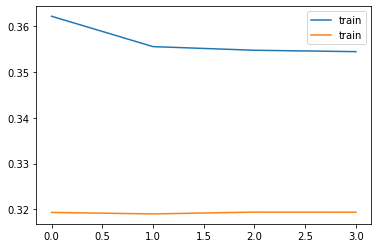

In [62]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_mean_squared_error'], label='train')
plt.legend();

In [26]:
y_pred = model.predict(X_test)

In [27]:
y_train_inv = availability_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = availability_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = availability_transformer.inverse_transform(y_pred)

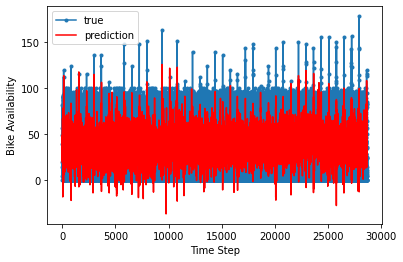

In [28]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Availability')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [29]:
def get_mean_absolute_deviations(predictions,actual_values):
    predictions_dataframe = pd.DataFrame(data = predictions.flatten())
    actual_test_set_values_dataframe = pd.DataFrame(data=actual_values.flatten())

    print("LSTM model prediction's Mean Absolute Deviation is ", predictions_dataframe.mad()[0])
    print("Test set's Mean Absolute Deviation is", actual_test_set_values_dataframe.mad()[0])

In [30]:
get_mean_absolute_deviations(y_pred_inv,y_test_inv)

LSTM model prediction's Mean Absolute Deviation is  8.58245
Test set's Mean Absolute Deviation is 25.223128863243673


In [31]:
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred, sample_weight=None, multioutput="uniform_average"))

Mean Absolute Error: 0.5407962035388925
